In [ ]:
# Install required libaries
!pip install tweepy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install numpy
!pip install gensim
!pip install seaborn
!pip install bokeh
!pip install pyldavis==2.1.2
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem.porter import *
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import os.path
import tweepy
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import nltk
import spacy
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Questions we are looking to answer about the Farmers Protest in India:
1) What are the main concerns or topics that are being discussed related to farmers protest in India - Topic modelling
2) What are the general reaction or sentiment of the crowd towards each topic - Sentiment Analysis
3) Which all celebrities voiced out their opinions about the issue?
4) How does the public (within and/or outside India) feel towards celebrities?

## Set up config information

In [2]:
# CSV Names
RAW_CSV_NAME = "raw_tweets.csv"
PREPROCESSED_CSV_NAME = "preprocessed_tweets.csv"

# Twitter API Credentials
CONSUMER_KEY = "hnGPJx6xBsudTgwOAxd0UNGUW"
CONSUMER_SECRET = "JcxhisQeF19hlEHRdeBifU3aL4R9DP9BWEMjYJ7MtnGcWaxn0p"
ACCESS_KEY = "1249286455530123264-5LbTPxHcE8Hl3CHhWztOsycMGEViHT"
ACCESS_SECRET = "4vdHhFP3odtZSUAKkK6GgPm7Vl03EHwvbP7cRTLFmQbFf"

pd.set_option('display.max_colwidth', -1)

<ipython-input-2-417303d6515a>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Load Tweets

In [3]:
USE_OLD_CSV = True

if not USE_OLD_CSV or not os.path.isfile(RAW_CSV_NAME):
    # Connect to API
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # Query the API
    search_term = "FarmersProtest"
    max_items = 50000
    result_type = "recent"
    lang = "en"
    # Do not include retweets, ensure tweet has 1 minimum retweet and is after September 2020        
    response = tweepy.Cursor(api.search, q=search_term+"-filter:retweets min_retweets:1 since:2020-09-01",
                             result_type=result_type, lang=lang, tweet_mode="extended").items(max_items)

    # Extract only the required keys from the response
    tweets = [
        [tweet.created_at,
         tweet.full_text,
         tweet.retweet_count,
         tweet.favorite_count,
         tweet.user.screen_name,
         tweet.user.followers_count,
         tweet.user.verified,
         tweet.author.location
        ] for tweet in response]

    # Store as CSV for later
    tweets_df = pd.DataFrame(data=tweets, columns=["created_at", "text", "retweet_count", "favorite_count",
    "user_screen_name", "user_followers_count", "user_verified","country"])
    tweets_df.to_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

raw_tweets = pd.read_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8')

## Preprocessing

In [4]:
tweets_df = raw_tweets.copy()
tweets_df['text_processed'] = raw_tweets['text']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove any hashtags
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
print(processed_tweets_df['text_processed'].head())
processed_tweets_df.to_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

0    Proud moment for us congratulations ugraha ji and Tikat sir                                                                                                                                                       
1    UPDATE Bapu Sukhdev Singh ji has been released from jail Bapu Ji with our legal team Panjaab Lawyers Senior Advocate Paramjeet Singh Full video from todays release                                               
2    Found this one on Instragram page of SaffronStudios page                                                                                                                                                          
3    The country is proud of Punjabis The people who are still protesting against your stupid laws Had people protested during Demonetization /GST and all these 7 years we wouldnt have seen this India Bravo Punjabis
4    What a poetic message to Modi Gov                                                                                                  

 ## Word Cloud

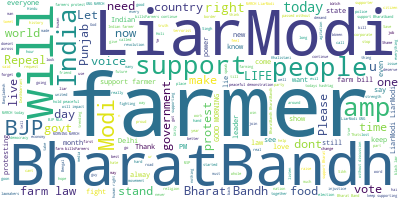

In [5]:
processed_tweets_df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

# join the words of the different tweets together into one string
long_string = ' '.join([text for text in processed_tweets_df['text_processed']])
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

# Topic Modelling

In [6]:
stop_words = stopwords.words('english')

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])
# create a dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create a corpus
texts = data_lemmatized

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

#Identify TF-IDF and use this as corpus
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

[['proud', 'moment', 'congratulation', 'ugraha', 'tikat', 'sir']]


In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [8]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

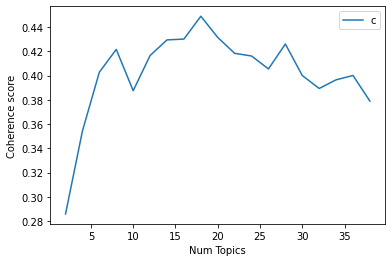

Num Topics = 2  has Coherence Value of 0.2859
Num Topics = 4  has Coherence Value of 0.3544
Num Topics = 6  has Coherence Value of 0.4028
Num Topics = 8  has Coherence Value of 0.4216
Num Topics = 10  has Coherence Value of 0.3875
Num Topics = 12  has Coherence Value of 0.4165
Num Topics = 14  has Coherence Value of 0.4294
Num Topics = 16  has Coherence Value of 0.4301
Num Topics = 18  has Coherence Value of 0.4489
Num Topics = 20  has Coherence Value of 0.4315
Num Topics = 22  has Coherence Value of 0.4183
Num Topics = 24  has Coherence Value of 0.4161
Num Topics = 26  has Coherence Value of 0.4055
Num Topics = 28  has Coherence Value of 0.426
Num Topics = 30  has Coherence Value of 0.4
Num Topics = 32  has Coherence Value of 0.3894
Num Topics = 34  has Coherence Value of 0.3965
Num Topics = 36  has Coherence Value of 0.4001
Num Topics = 38  has Coherence Value of 0.3789


In [9]:
# Show graph
start=2; limit=40; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

With the coherence score seems to keep increasing with the number of topics, it may make better sense to pick the model that gave the highest CV before flattening out or a major drop. In this case, we picked *k=22*

In [10]:
num_topics=22

In [11]:
# Select the model and print the topics
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(19,
  '0.069*"do" + 0.043*"real" + 0.034*"entire" + 0.033*"purpose" + 0.032*"mein" '
  '+ 0.030*"back" + 0.030*"alive" + 0.023*"see" + 0.018*"support" + '
  '0.013*"farmer"'),
 (21,
  '0.099*"ban_evm" + 0.035*"bow" + 0.026*"system" + 0.025*"brotherhood" + '
  '0.025*"masse" + 0.024*"find" + 0.024*"bharatbandh" + 0.021*"poor" + '
  '0.020*"enter" + 0.020*"farmer"'),
 (12,
  '0.065*"bharatbandh" + 0.051*"support" + 0.048*"feel" + 0.033*"focus" + '
  '0.030*"bjp" + 0.026*"farmer" + 0.021*"deathwarrant" + 0.020*"modi" + '
  '0.019*"trend" + 0.018*"retweet"'),
 (2,
  '0.100*"farmer" + 0.036*"food" + 0.029*"today" + 0.026*"muslim" + '
  '0.023*"anymore" + 0.021*"keep" + 0.018*"support" + 0.016*"voice" + '
  '0.015*"awareness" + 0.013*"loud"'),
 (17,
  '0.053*"force" + 0.044*"hope" + 0.036*"live" + 0.032*"way" + 0.030*"close" + '
  '0.027*"legal" + 0.026*"other" + 0.026*"public" + 0.026*"country" + '
  '0.023*"demand"'),
 (14,
  '0.067*"bharatbandh" + 0.041*"modi" + 0.038*"brain" + 0.034*"f

### What is the Dominant topic and its percentage contribution in each tweet

In [12]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5979,"break, farmer, ego, heart, class, supply, careful, nature, i, thinking",Proud moment for us congratulations ugraha ji and Tikat sir
1,1,19.0,0.6083,"do, real, entire, purpose, mein, back, alive, see, support, farmer",UPDATE Bapu Sukhdev Singh ji has been released from jail Bapu Ji with our legal team Panjaab Lawyers Senior Advocate Paramjeet Singh Full video from todays release
2,2,11.0,0.6793,"role, bad, tweet, strongly, learn, public, demonstration, criminal, never, khela",Found this one on Instragram page of SaffronStudios page
3,3,12.0,0.6682,"bharatbandh, support, feel, focus, bjp, farmer, deathwarrant, modi, trend, retweet",The country is proud of Punjabis The people who are still protesting against your stupid laws Had people protested during Demonetization /GST and all these 7 years we wouldnt have seen this India Bravo Punjabis
4,4,0.0,0.8085,"break, farmer, ego, heart, class, supply, careful, nature, i, thinking",What a poetic message to Modi Gov
5,5,0.0,0.9130,"break, farmer, ego, heart, class, supply, careful, nature, i, thinking",Europe PLEASE can you advise if the World Health Organisation certified these products and brand and do they actually work?
6,6,3.0,0.3504,"bharatbandh, farmer, totally, food, job, singh, hai, railway, deep, turn",Action Reaction
7,7,5.0,0.9044,"bharatbandh, deathwarrant, farmer, part, inform, update, active, support, need, unity",What farmers require is that the prices should be moderate and the markets steady and for this reason we need MSP
8,8,14.0,0.6102,"bharatbandh, modi, brain, farmer, appreciate, government, s, become, right, deathwarrant",kaur sohal4 Very beautifully written
9,9,15.0,0.7042,"angry, farmer, farm, cover, common, gas, plan, hindu, freedom, economy",Thanks everyone for follow me Special thanks to mare vere nu god bless you and all farmers supporters


### The most representative sentence for each topic

In [13]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9522,"break, farmer, ego, heart, class, supply, careful, nature, i, thinking",We got English professor I will use whatever I want and write whatever I want My tweets meri marzi didi once again Modi is a extra ordinary lahnti Now what are you paying for my tuition fee?? LiarModi
1,1.0,0.9565,"bharat, woman, machine, stay, beg, talk, farmer, get, discuss, story",He lied about ending terrorism He lied about doubling the farmers incomeHe lied about demonetisation He lied about 15 lakh He lied about Employment He lied about cheap petrol ratesHe lied about strong rupee LiarModi
2,2.0,0.9646,"farmer, food, today, muslim, anymore, keep, support, voice, awareness, loud",Bhakats mocked on the death of 300 plus farmers Bhakats mocked when a bullet fired on Navneet Bhakat called farmers Terrorists Anti Nationals bhakats Mocked on Peaceful protest (as per Indian Constitution) but bhakat did not mock what PM lied in Bengal??
3,3.0,0.9718,"bharatbandh, farmer, totally, food, job, singh, hai, railway, deep, turn",Khalistani word has been giveb tag of terr0rists in 1980s which is wrong &amp nvr got rectifiedKhalsa means pure Khalsa mero roop hai khaasKhalse mei hoon kru niwaas ~ Guru Gobind Singh Ji I think this word is portrayed very wrongly &amp nvr rectified
4,4.0,0.9585,"bangladesh, bharatbandh, go, world, d, shah, bus, essential, gon, date",accepted &amp gave weak to persecuted groups ie Even essential anti NRC protest fizzled&amp should have but didnt join in large numbers Muslims must now support strong leadership of /3
5,5.0,0.9402,"bharatbandh, deathwarrant, farmer, part, inform, update, active, support, need, unity",MSP????Who is giving MSP to farmers???In India The farmer never gets full compensation for the crop destroyed by natural calamities LiarModi
6,6.0,0.9584,"society, worker, farmer, india, country, tune, evm, bharatbandh, happen, food",Read the bills with issues explained and dont act like a foolish In the future ur job might be in danger if you dont stand with the truth now youll speak irrelevant things Check your previous comment Nothing makes sense LiarModi
7,7.0,0.9681,"bharatbandh, farmer, protest, bharat_bandh, support, march, go, india, road, face",BJP MLA Narang faced heat of agitation when his clothes were torn apart by farmers and ink was thrown at him Narang had gone to attend PC at Malout Notably Narang has always said that farmer protest is Khalistani protest lwade ke farmer hai ye saale
8,8.0,0.9470,"support, farmer, bharatbandh, people, main, fight, movement, thank, farm, life",75Truth prevailsNo one can silence the voice of truth Farmers continue to hold peaceful demonstrations Farm Bills were passed without discussion with the people they will impact the most the farmers Repeal the farm bills
9,9.0,0.9436,"damage, bjp, body, country, leader, bharatbandh, whole, educate, save, democracy",After 2nd May when BJP wins West Bengal ye frustrated sardaar logon se puchnege ki vote kisko diya jisne BJP bola uski kutaai


### Frequency Distribution of Word Counts in Documents

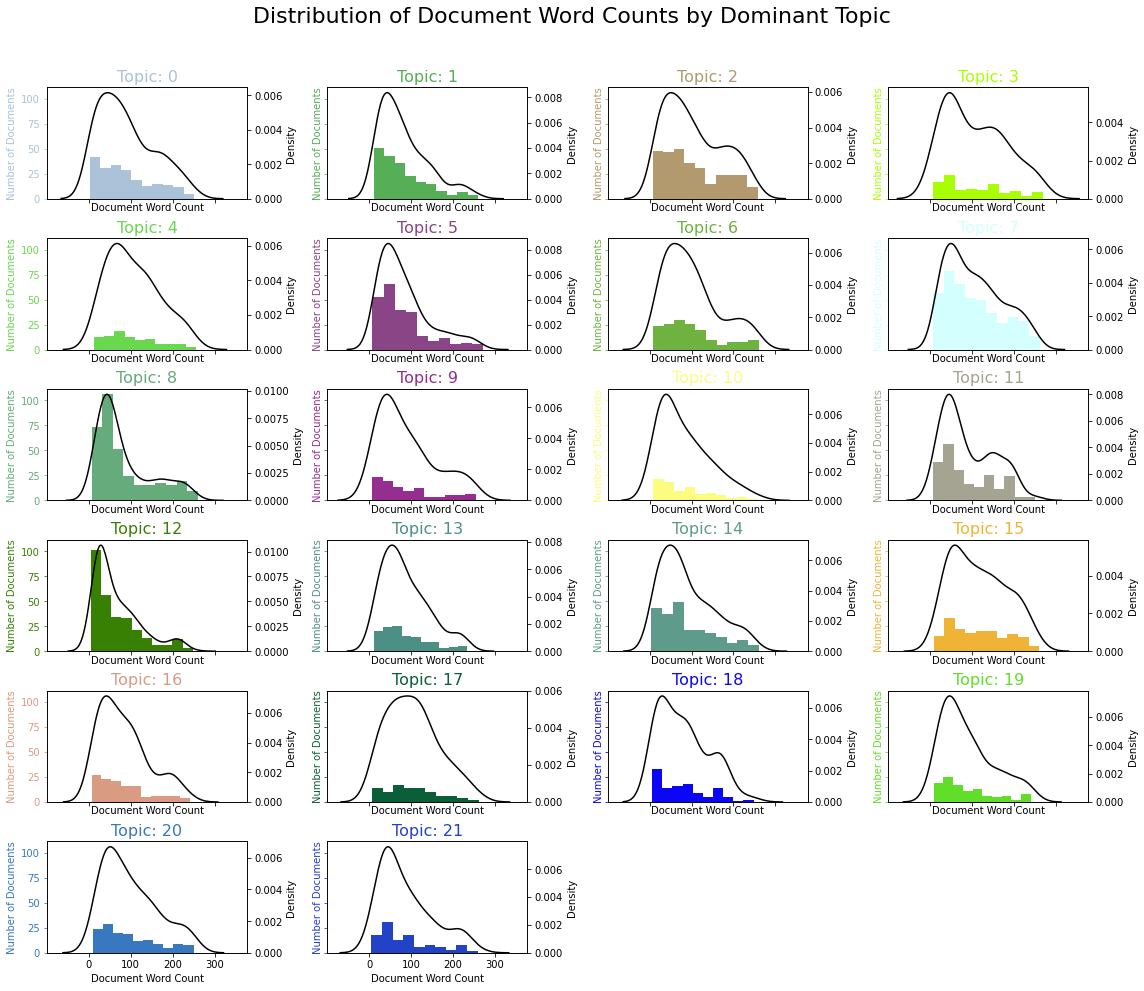

In [14]:
doc_lens = [len(d) for d in df_dominant_topic.Text]
cols = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

fig, axes = plt.subplots(6,4,figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):  
    if i<num_topics:
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
    else:
        ax.set_visible(False)

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

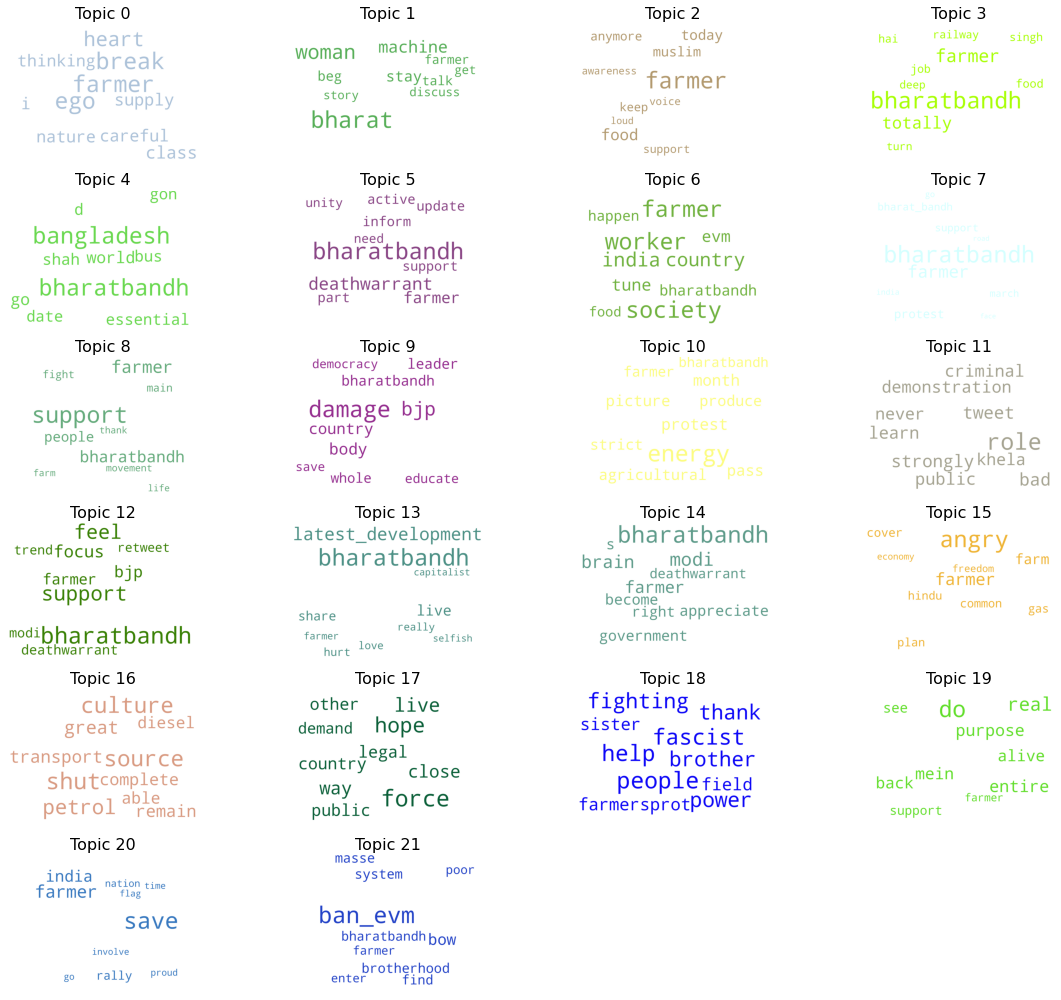

In [15]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=num_topics, num_words=10)

fig, axes = plt.subplots(6, 4, figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    else:
        ax.set_visible(False)


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

<ipython-input-16-da26c95b3c90>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-da26c95b3c90>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-da26c95b3c90>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-da26c95b3c90>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-da26c95b3c90>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation

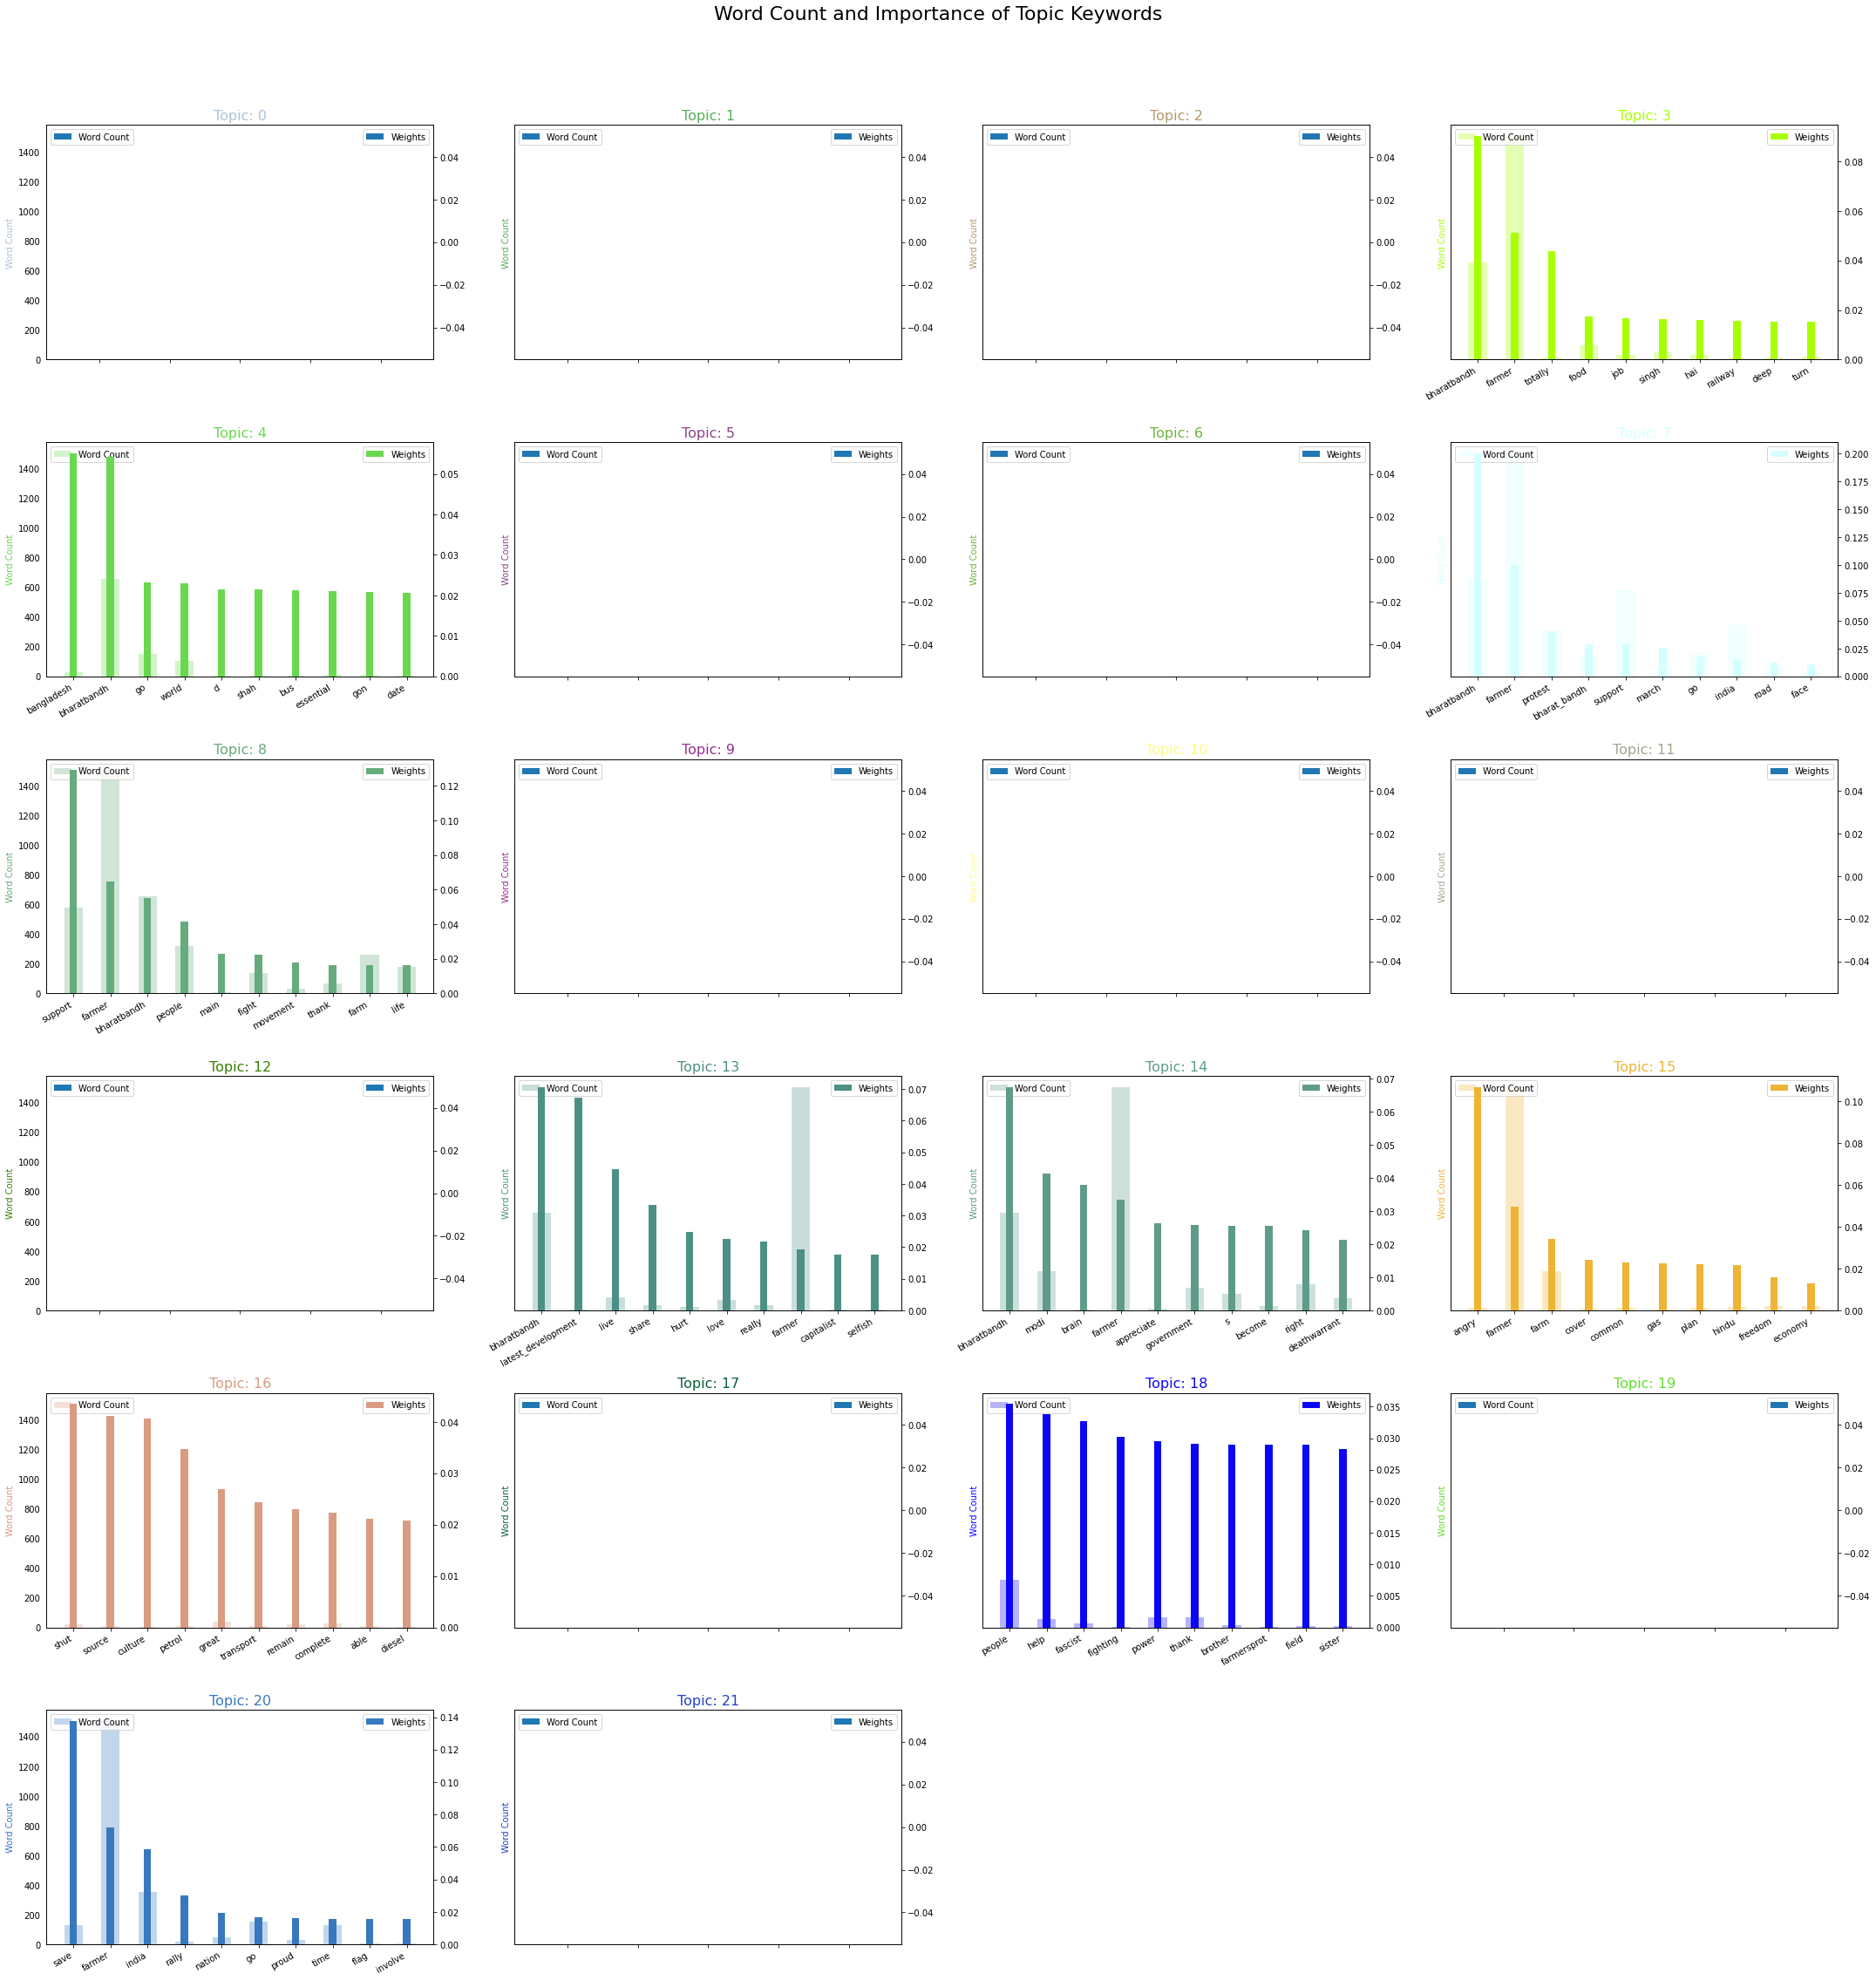

In [16]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(6, 4, figsize=(30,30), sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
#         ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    else:
        ax.set_visible(False)
        

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Compute Model Perplexity and Coherence Score

In [17]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.978145377406554

Coherence Score:  0.4183442647169928


### t-distributed stochastic neighbor embedding Clustering Chart

In [18]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    row = row_list[0] if optimal_model.per_word_topics else row_list 
    topic_weights.append([w for i, w in row])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(num_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=cols[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3623 samples in 0.001s...
[t-SNE] Computed neighbors for 3623 samples in 0.485s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3623
[t-SNE] Computed conditional probabilities for sample 2000 / 3623
[t-SNE] Computed conditional probabilities for sample 3000 / 3623
[t-SNE] Computed conditional probabilities for sample 3623 / 3623
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.318222
[t-SNE] KL divergence after 1000 iterations: 0.489398


Loading BokehJS ...

In [19]:
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./topic-modelled-'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './topic-modelled-'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7     -0.216679  0.044801  1       1        9.468096
2      0.019541  0.172607  2       1        7.317591
8     -0.048315 -0.006235  3       1        7.046791
14    -0.072472 -0.065894  4       1        5.839381
15     0.037703  0.045836  5       1        5.594422
5     -0.165814 -0.003504  6       1        5.453617
12    -0.062319 -0.054073  7       1        5.002123
0      0.090381  0.055542  8       1        4.796398
6     -0.029484  0.085424  9       1        4.762114
1      0.093720 -0.040980  10      1        4.717975
11     0.153480 -0.027341  11      1        4.450248
20     0.000619  0.178479  12      1        4.038884
3     -0.085616  0.031829  13      1        3.736991
4     -0.026943 -0.101919  14      1        3.536254
16     0.099393 -0.031546  15      1        3.486392
13    -0.074529 -0.115112  16      1        3.360753
17     0.047362 -0.119074  17      1        3.222722
9     -0.031104 -0.041823  18      1        3.032721
19     0.128405  0.012155  19      1        2.923785
18     0.062446 -0.039061  20      1        2.906028
21     0.038289  0.021313  21      1        2.886558
10     0.041937 -0.001426  22      1        2.420155, topic_info=             Term         Freq        Total Category  logprob  loglift
1288  bharatbandh  1711.000000  1711.000000  Default  30.0000  30.0000
2685  angry        215.000000   215.000000   Default  29.0000  29.0000
712   save         316.000000   316.000000   Default  28.0000  28.0000
327   support      781.000000   781.000000   Default  27.0000  27.0000
1179  ban_evm      102.000000   102.000000   Default  26.0000  26.0000
...       ...             ...          ...       ...      ...      ...
718   liarmodi     4.113297     202.131892   Topic22 -5.3404  -0.1734 
59    need         3.503722     131.186238   Topic22 -5.5008   0.0985 
248   border       2.387074     19.992937    Topic22 -5.8846   1.5960 
147   go           2.893224     238.007143   Topic22 -5.6923  -0.6886 
156   amp          2.482612     216.308448   Topic22 -5.8453  -0.7461 

[1207 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
260   13     0.415932  aap      
176   13     0.035248  able     
176   15     0.916453  able     
3049  18     0.640107  ache     
1390  6      0.970143  active   
...   ..          ...   ...     
1503  12     0.030177  yesterday
1503  15     0.030177  yesterday
1425  21     0.435829  young    
4080  13     0.414588  yudhveer 
2999  10     0.711181  zirakpur 

[3208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 9, 15, 16, 6, 13, 1, 7, 2, 12, 21, 4, 5, 17, 14, 18, 10, 20, 19, 22, 11])

## Sentiment Analysis

Chores: 
* Once the new data is available tweet the number of topics based on that
* From the top keywords, and sample tweets formalise the topics/ concerns

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.

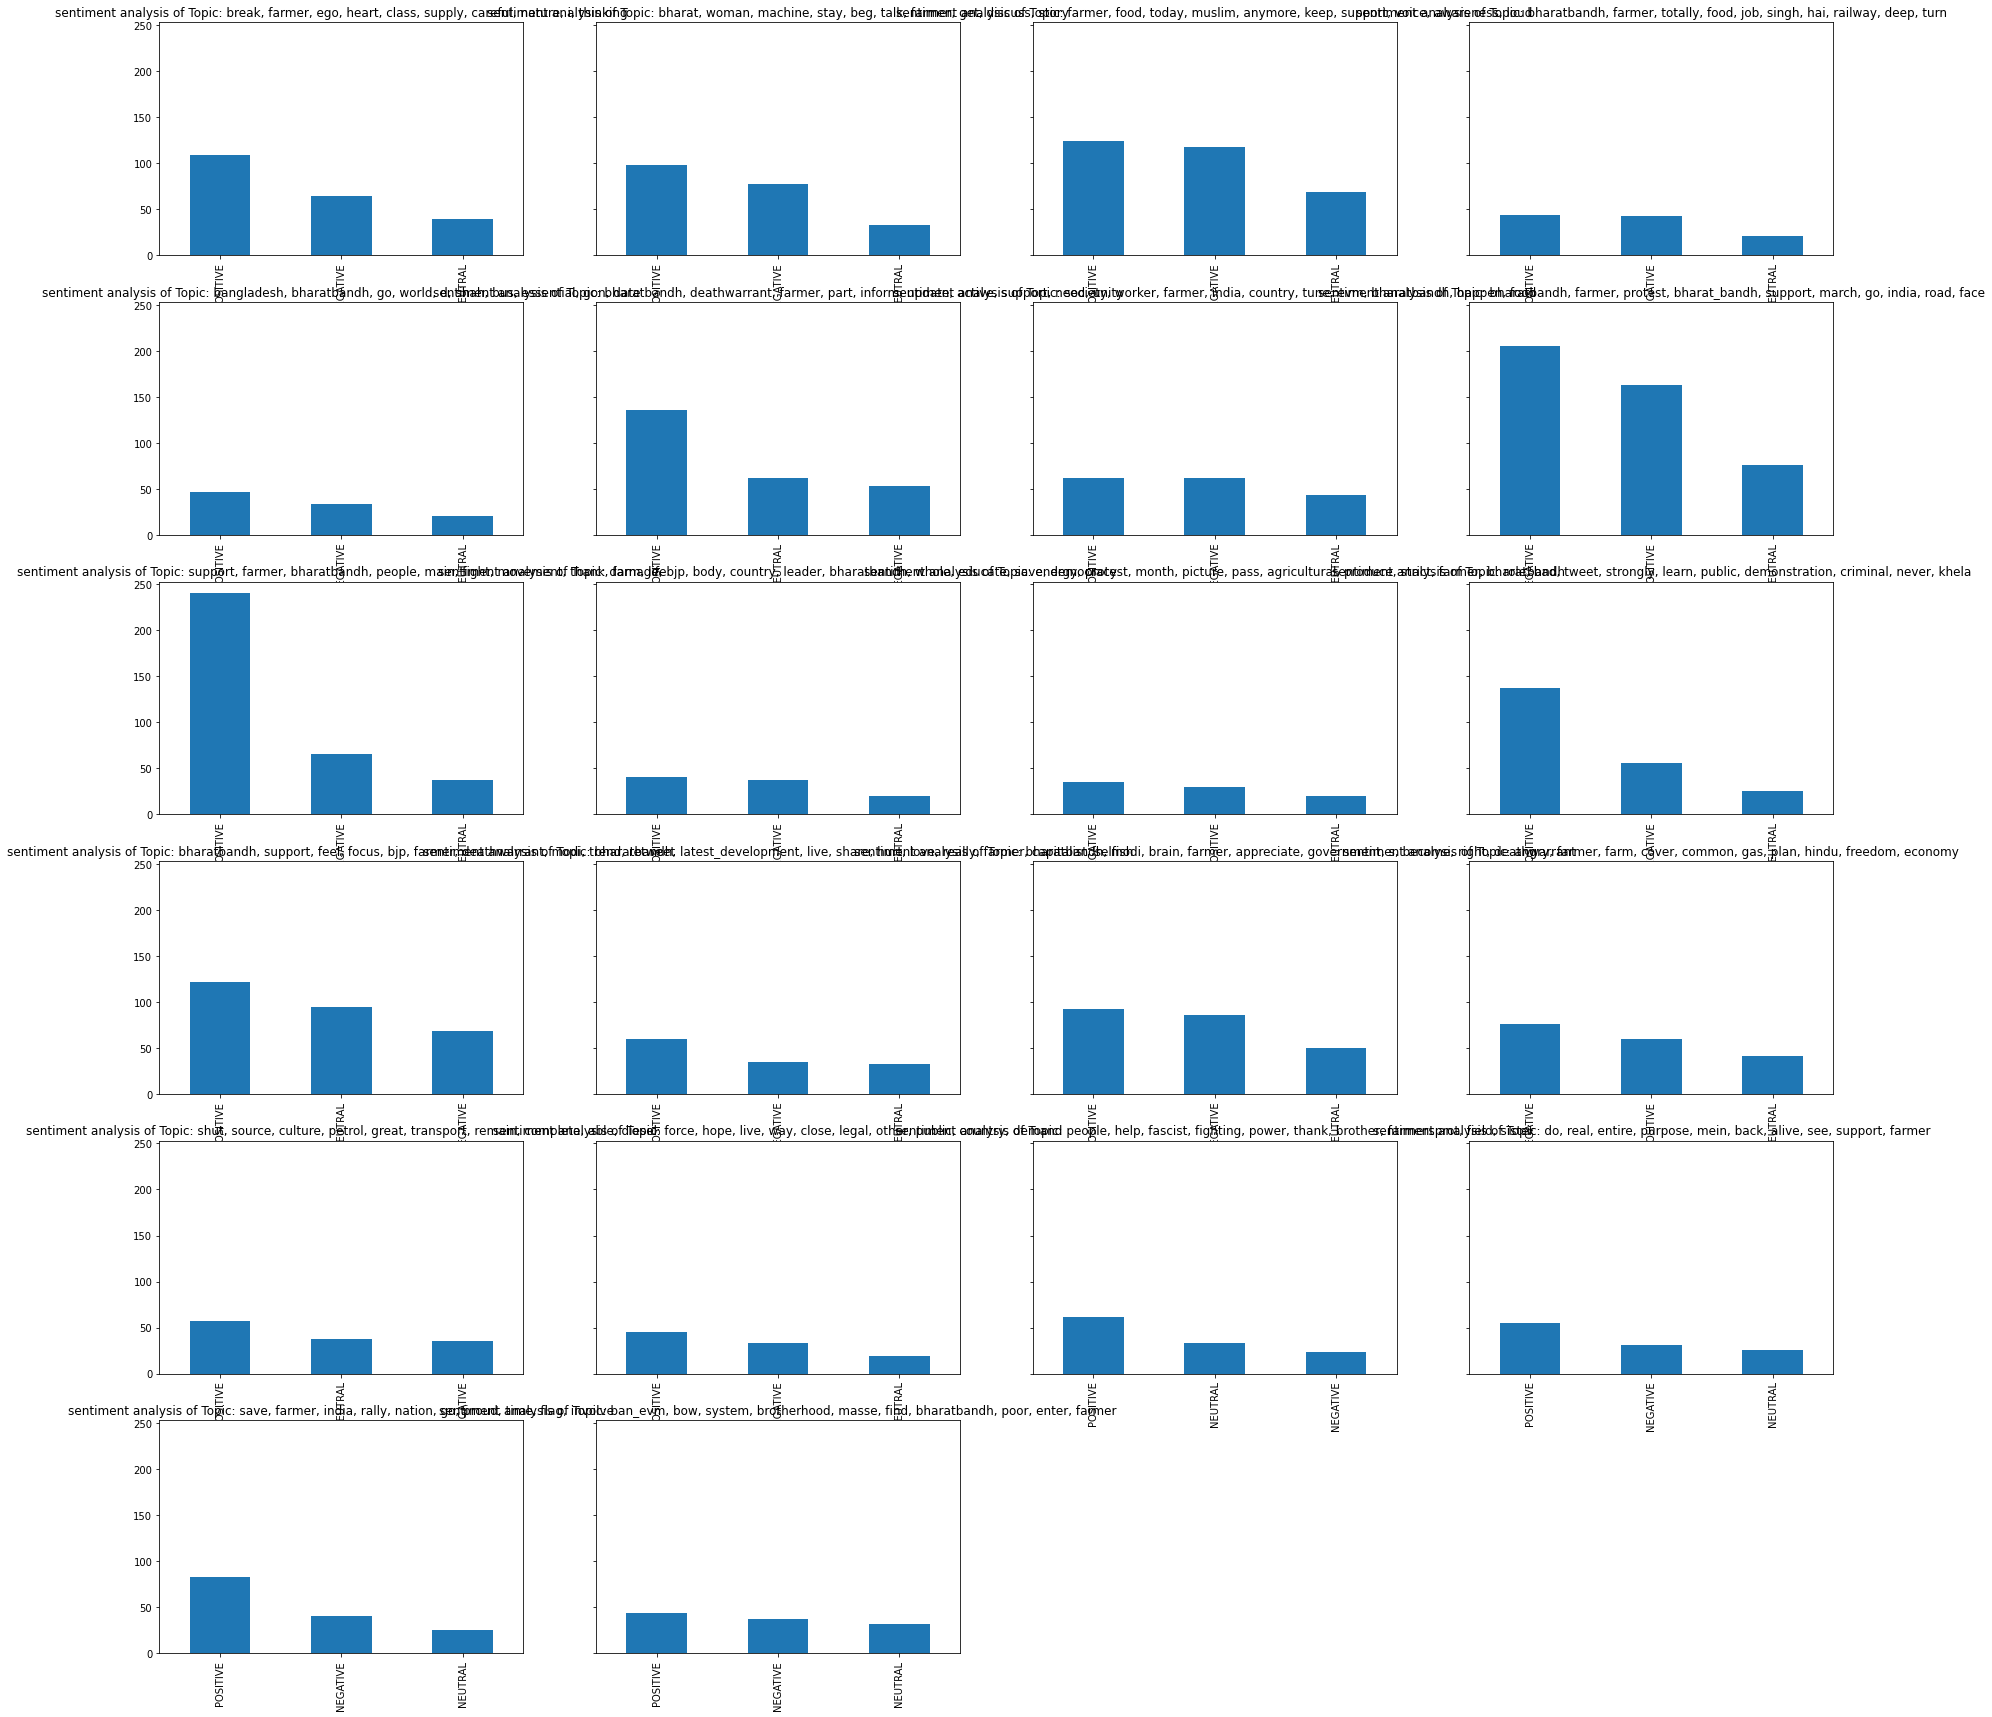

In [22]:
Topics =  list(sent_topics_outdf_grpd)
fig, axes = plt.subplots(6, 4, figsize=(30,30), sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        topic = Topics[i][1]
        sid = SentimentIntensityAnalyzer()
        df = pd.DataFrame()
        df["text_processed"]=topic[0].to_numpy()
        df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

        df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
        df['sentiment_type']=''
        df.loc[df.compound>0,'sentiment_type']='POSITIVE'
        df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
        df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
        df.sentiment_type.value_counts().plot.bar(ax=ax,title="sentiment analysis of Topic: "+topic["Topic_Keywords"].iloc[0])
    else:
        ax.set_visible(False)

## Named Entity Recognition

In [23]:
import spacy
import en_core_web_trf

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:

Topics = ['bjp', 'repeal', 'modi', 'protest','farm laws']

for i in Topics:
    
    df = pd.read_csv('preprocessed_tweets.csv', quotechar='"', encoding='utf8')
    
    sub = i
    
    df['indexes'] = df['text_processed'].str.find(sub)
    
    # Get names of indexes which does not have the topic
    indexNames = df[ df['indexes'] == -1 ].index
    # Delete these row indexes from dataFrame
    df.drop(indexNames , inplace=True)
    #save for NER
    unique_tweets = df

unique_tweets_list = list(unique_tweets['text_processed'].values)

#Use a spacy model trained using our own dataset
nlp = spacy.load(r".\spacy_trained_model")


entities = list()

for tweet_text in unique_tweets_list:
  doc = nlp(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, ne.text,"--",tweet_text)
    entities.append(ne.text)

#print(entities)



/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OSError: [E050] Can't find model '.\spacy_trained_model'. It doesn't seem to be a Python package or a valid path to a data directory.